### Modified from the ICESat-2 data tutorial

#### original authors: Scott Henderson, Anthony Arendt, David Shean, University of Washington

In [1]:
%matplotlib inline
import os
import s3fs
import xarray as xr
import h5py
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import cartopy.crs as ccrs
from mpl_toolkits.mplot3d import Axes3D

### Initial steps are disabled via `if False` to avoid accidentally running them

In [12]:
# mount S3 as if it was a file system

if False: 
    bucket = 'pangeo-data-upload-oregon'
    fs = s3fs.S3FileSystem()

# List contents of the bucket

if False:
    dataDir = 'pangeo-data-upload-oregon/icesat2/atl06'
    s3List = fs.ls(dataDir)   
    print(s3List)

# work with the first data file

if False: 
    s3File = s3List[0]
    dataFile = format(s3File.split('/')[3])

# Download an HDF5 to home directory
# If data are in your git directory: Be sure to .gitignore .h5 files so they are not pushed to GitHub.

if False:
    fs.get(s3File, dataFile)

### Using h5py to look at the dataset structure

ICESat-2 data are structured in h5 files with multiple group levels. To find what you need it helps to view these groups. 

In [92]:
datafiles = os.listdir('/home/jovyan/data/icesat2/')
source = ['/home/jovyan/data/icesat2/' + df for df in datafiles]
datafile = source[0]
f = h5py.File(datafile,'r')
print(type(f), '\n\n\n')

# HDF5 behaves like a nested dictionary or if you like as a file system containing data

groups = list(f.keys())              # groups is a list of file keys; there are 10 including 6 for the icesat2 beams

print("Here is the top level directory of the HDF5 file:\n")
for g in groups: print(g)            # treated as a list of key strings: The "top level directory contents"
    
print('\n\n\n')

for g in groups:
    print('---','Group: {}'.format(g), '---')
    group = f[g]                                      # 'g' is a dictionary key. Values are a list of keys
    for d in group.keys(): print('    ', group[d])

<class 'h5py._hl.files.File'> 



Here is the top level directory of the HDF5 file:

METADATA
ancillary_data
gt1l
gt1r
gt2l
gt2r
gt3l
gt3r
orbit_info
quality_assessment




--- Group: METADATA ---
     <HDF5 group "/METADATA/AcquisitionInformation" (4 members)>
     <HDF5 group "/METADATA/DataQuality" (2 members)>
     <HDF5 group "/METADATA/DatasetIdentification" (0 members)>
     <HDF5 group "/METADATA/Extent" (0 members)>
     <HDF5 group "/METADATA/Lineage" (13 members)>
     <HDF5 group "/METADATA/ProcessStep" (4 members)>
     <HDF5 group "/METADATA/ProductSpecificationDocument" (0 members)>
     <HDF5 group "/METADATA/QADatasetIdentification" (0 members)>
     <HDF5 group "/METADATA/SeriesIdentification" (0 members)>
--- Group: ancillary_data ---
     <HDF5 dataset "atlas_sdp_gps_epoch": shape (1,), type "<f8">
     <HDF5 dataset "control": shape (1,), type "|S100000">
     <HDF5 dataset "data_end_utc": shape (1,), type "|S27">
     <HDF5 dataset "data_start_utc": shape (1,), ty

The key for ground track 3-right:
      gt3r 

The keys for gt3r:
 <KeysViewHDF5 ['land_ice_segments', 'residual_histogram', 'segment_quality']> 

That first key, being land_ice_segments:
 land_ice_segments 

the keys for land_ice_segments:
<KeysViewHDF5 ['atl06_quality_summary', 'delta_time', 'h_li', 'h_li_sigma', 'latitude', 'longitude', 'segment_id', 'sigma_geo_h', 'bias_correction', 'dem', 'fit_statistics', 'geophysical', 'ground_track']>
the first land ice height: 
 1647.5017 

18 18 18


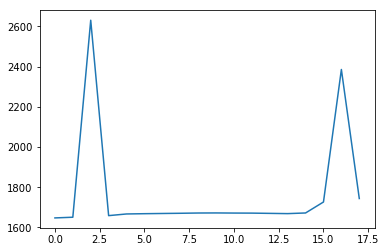

In [93]:
toplevel=f.keys()
a=list(toplevel)[7]

print('The key for ground track 3-right:')
print('     ', a, '\n')

b = f[a].keys()

print('The keys for gt3r:\n', b, '\n')

c = list(b)[0]

print('That first key, being land_ice_segments:\n', c, '\n')

print('the keys for land_ice_segments:')
print(f[a][c].keys())

d=list(f[a][c]['h_li'])[0]

print('the first land ice height: \n', d, '\n')

is_h = list(f[a][c]['h_li'])
is_lat = list(f[a][c]['latitude'])
is_lon = list(f[a][c]['longitude'])
print(len(is_h), len(is_lat), len(is_lon))
plt.plot(is_h)


In [94]:
f.close()

### Enter xarray

Let's use gt3r/land_ice_segments.


In [99]:
# print(source)

In [100]:
ds = xr.open_dataset(source[11],group='/gt3r/land_ice_segments')
print(ds)

<xarray.Dataset>
Dimensions:                (delta_time: 39958)
Coordinates:
  * delta_time             (delta_time) datetime64[ns] 2018-12-20T09:36:48.213849172 ... 2018-12-20T09:39:26.253514536
    latitude               (delta_time) float64 ...
    longitude              (delta_time) float64 ...
Data variables:
    atl06_quality_summary  (delta_time) int8 ...
    h_li                   (delta_time) float32 ...
    h_li_sigma             (delta_time) float32 ...
    segment_id             (delta_time) float64 ...
    sigma_geo_h            (delta_time) float32 ...
Attributes:
    Description:  The land_ice_height group contains the primary set of deriv...
    data_rate:    Data within this group are sparse.  Data values are provide...


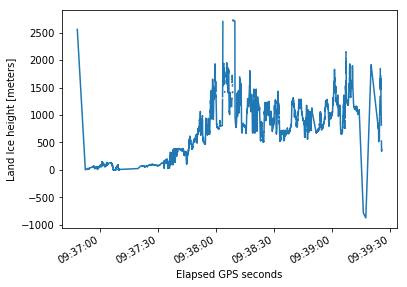

In [101]:
ds.h_li.plot()

### Convert to Pandas dataframe

In [102]:
df = ds.to_dataframe()
df.head(6)

,atl06_quality_summary,h_li,h_li_sigma,latitude,longitude,segment_id,sigma_geo_h
delta_time,,,,,,,
2018-12-20 09:36:48.213849172,1,2557.222168,1.428088,69.526448,-133.306173,614906.0,100.003555
2018-12-20 09:36:52.379081008,1,3.342980,0.184113,69.263414,-133.397066,616383.0,100.000809
2018-12-20 09:36:52.381889812,0,3.326010,0.094703,69.263236,-133.397125,616384.0,100.006287
2018-12-20 09:36:52.384692356,1,3.446003,0.091734,69.263058,-133.397183,616385.0,100.002129
2018-12-20 09:36:52.393101172,1,3.489338,0.084331,69.262523,-133.397358,616388.0,100.001686
2018-12-20 09:36:52.483478468,1,3.235131,0.288798,69.256825,-133.399314,616420.0,100.004051


## Make a simple 3D scatter plot

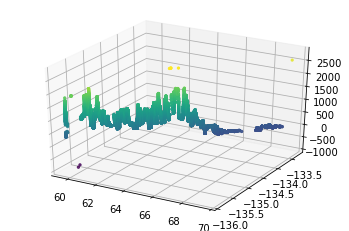

In [103]:
f = plt.figure()
ax3D = f.add_subplot(111, projection='3d')
sc = ax3D.scatter(df['latitude'], df['longitude'], df['h_li'], c=df['h_li'], marker='.')

## Convert the Pandas dataframe to a Geopandas dataframe

This mean the latitude and longitude columns are converted from just numbers into a geometry so Python knows where the data are in space.

In [104]:
df['geometry'] = list(zip(df['longitude'], df['latitude']))
df['geometry'] = df['geometry'].apply(Point)
gdf = gpd.GeoDataFrame(df)
df.head()

,atl06_quality_summary,h_li,h_li_sigma,latitude,longitude,segment_id,sigma_geo_h,geometry
delta_time,,,,,,,,
2018-12-20 09:36:48.213849172,1,2557.222168,1.428088,69.526448,-133.306173,614906.0,100.003555,POINT (-133.3061725925355 69.52644815418451)
2018-12-20 09:36:52.379081008,1,3.342980,0.184113,69.263414,-133.397066,616383.0,100.000809,POINT (-133.3970660628022 69.26341447610851)
2018-12-20 09:36:52.381889812,0,3.326010,0.094703,69.263236,-133.397125,616384.0,100.006287,POINT (-133.3971249787843 69.26323629382493)
2018-12-20 09:36:52.384692356,1,3.446003,0.091734,69.263058,-133.397183,616385.0,100.002129,POINT (-133.3971834768897 69.26305808562452)
2018-12-20 09:36:52.393101172,1,3.489338,0.084331,69.262523,-133.397358,616388.0,100.001686,POINT (-133.3973582090167 69.26252344590479)


### make a simple map

* get a geojson file with US state polygons
* use Cartopy to make a very simple map

In [105]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

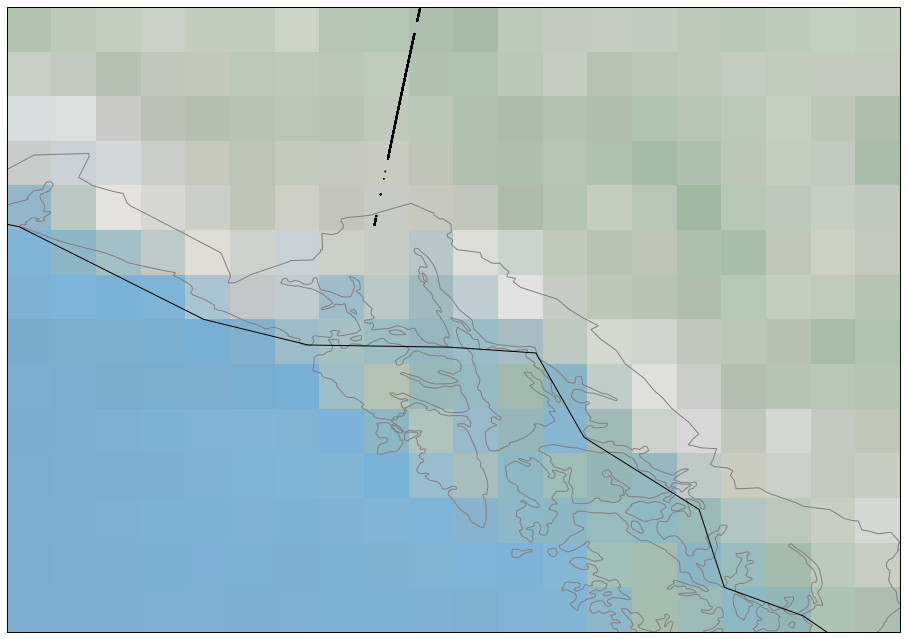

In [112]:
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-140,-130, 55, 62])
ax.stock_img()
states_gdf.plot(ax=ax, facecolor='none', edgecolor='gray')
gdf.plot(ax=ax, column='h_li', cmap='inferno', markersize=.5)
ax.coastlines()

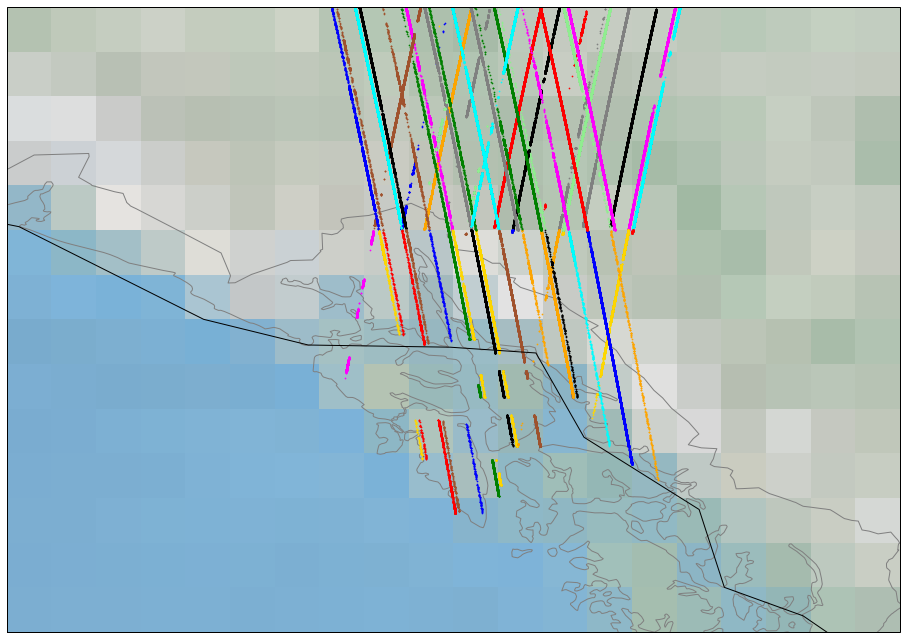

In [121]:
# create a geopandas data frame from state outlines for some added map context; particularly coastline
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-140,-130, 55, 62])
ax.stock_img()
states_gdf.plot(ax=ax, facecolor='none', edgecolor='gray')
ax.coastlines()

c=['sienna', 'gold', 'red', 'orange', 'lightgreen', 'green', 'cyan', 'blue', 'fuchsia', 'grey', 'black']
nc = len(c)

fi0 = 0
fi1 = len(source)
for i in range(fi0, fi1):
    ds = xr.open_dataset(source[i],group='/gt3r/land_ice_segments')
    df = ds.to_dataframe()
    df['geometry'] = list(zip(df['longitude'], df['latitude']))
    df['geometry'] = df['geometry'].apply(Point)
    gdf = gpd.GeoDataFrame(df)
    gdf.plot(ax=ax, color=c[i%nc], markersize=.5)    # see original for column/cmap combo to color
    ds.close()
